In [1]:
%run init_notebook.py

In [2]:
import spacy
import regex as re

import time
from itertools import compress
from collections import Counter
from src.utils import vec_similarity, arr_min_max_scale, save_pd_df

from matplotlib.pyplot import cm

from uuid import uuid4
import pickle

In [3]:
from articles import load_pickle, DICT_NARRATIVES, load_pd_df
from src.nlp_utils import get_spacy_NLP, load_raw_data
from src.nlp_lists import LST_FREQUENT_NON_MEANING

In [4]:
NLP = get_spacy_NLP('de')

# supervised narrative topics

news data

In [5]:
dict_txts = {}
for file in [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]:
    dict_txts[file.split('.')[0]] = load_pickle(file)

len(dict_txts)

1580

In [7]:
Counter([v['is_infl'] for k, v in dict_txts.items()])

Counter({True: 1580})

## analyse

In [8]:
_dict = {}
for idx, text in {k: v for k, v in dict_txts.items() if v['is_infl']}.items():
    counter = text['counter_nouns']
    for k, v in counter.items():
        if k not in LST_FREQUENT_NON_MEANING:
            if k not in _dict.keys():
                _dict[k] = v
            elif k in _dict.keys():
                _dict[k] = _dict[k] + v
c = sorted(_dict.items(), key=lambda x: x[1], reverse=True)

In [79]:
# sorted([i for i in c if "nachfrage" in i[0]],  key=lambda x: x[1], reverse=True)

# narrative scores

In [20]:
df = pd.DataFrame(
    {
        (dkey, doc['date']) : {
            nkey: narrative['narrative_score_det'] for nkey, narrative in doc['narratives'].items()
        } for dkey, doc in dict_txts.items()
    }
).T.sort_index()
df = df.reset_index(names=['id', 'date'])

In [21]:
df_g = df.drop('id', axis=1).groupby('date').sum().copy()
df_g.iloc[:, : ] = df_g.values #/ df.groupby('date').id.count().values[:,None]
df_g = df_g.rolling(15).mean()

In [18]:
df_g2 = df.drop('id', axis=1).groupby('date').sum().copy() #/ df.groupby('date').id.count()
df_g2.iloc[:, : ] = df_g2.values #/ df.groupby('date').id.count().values[:,None]
df_g2 = df_g2.rolling(15).mean()

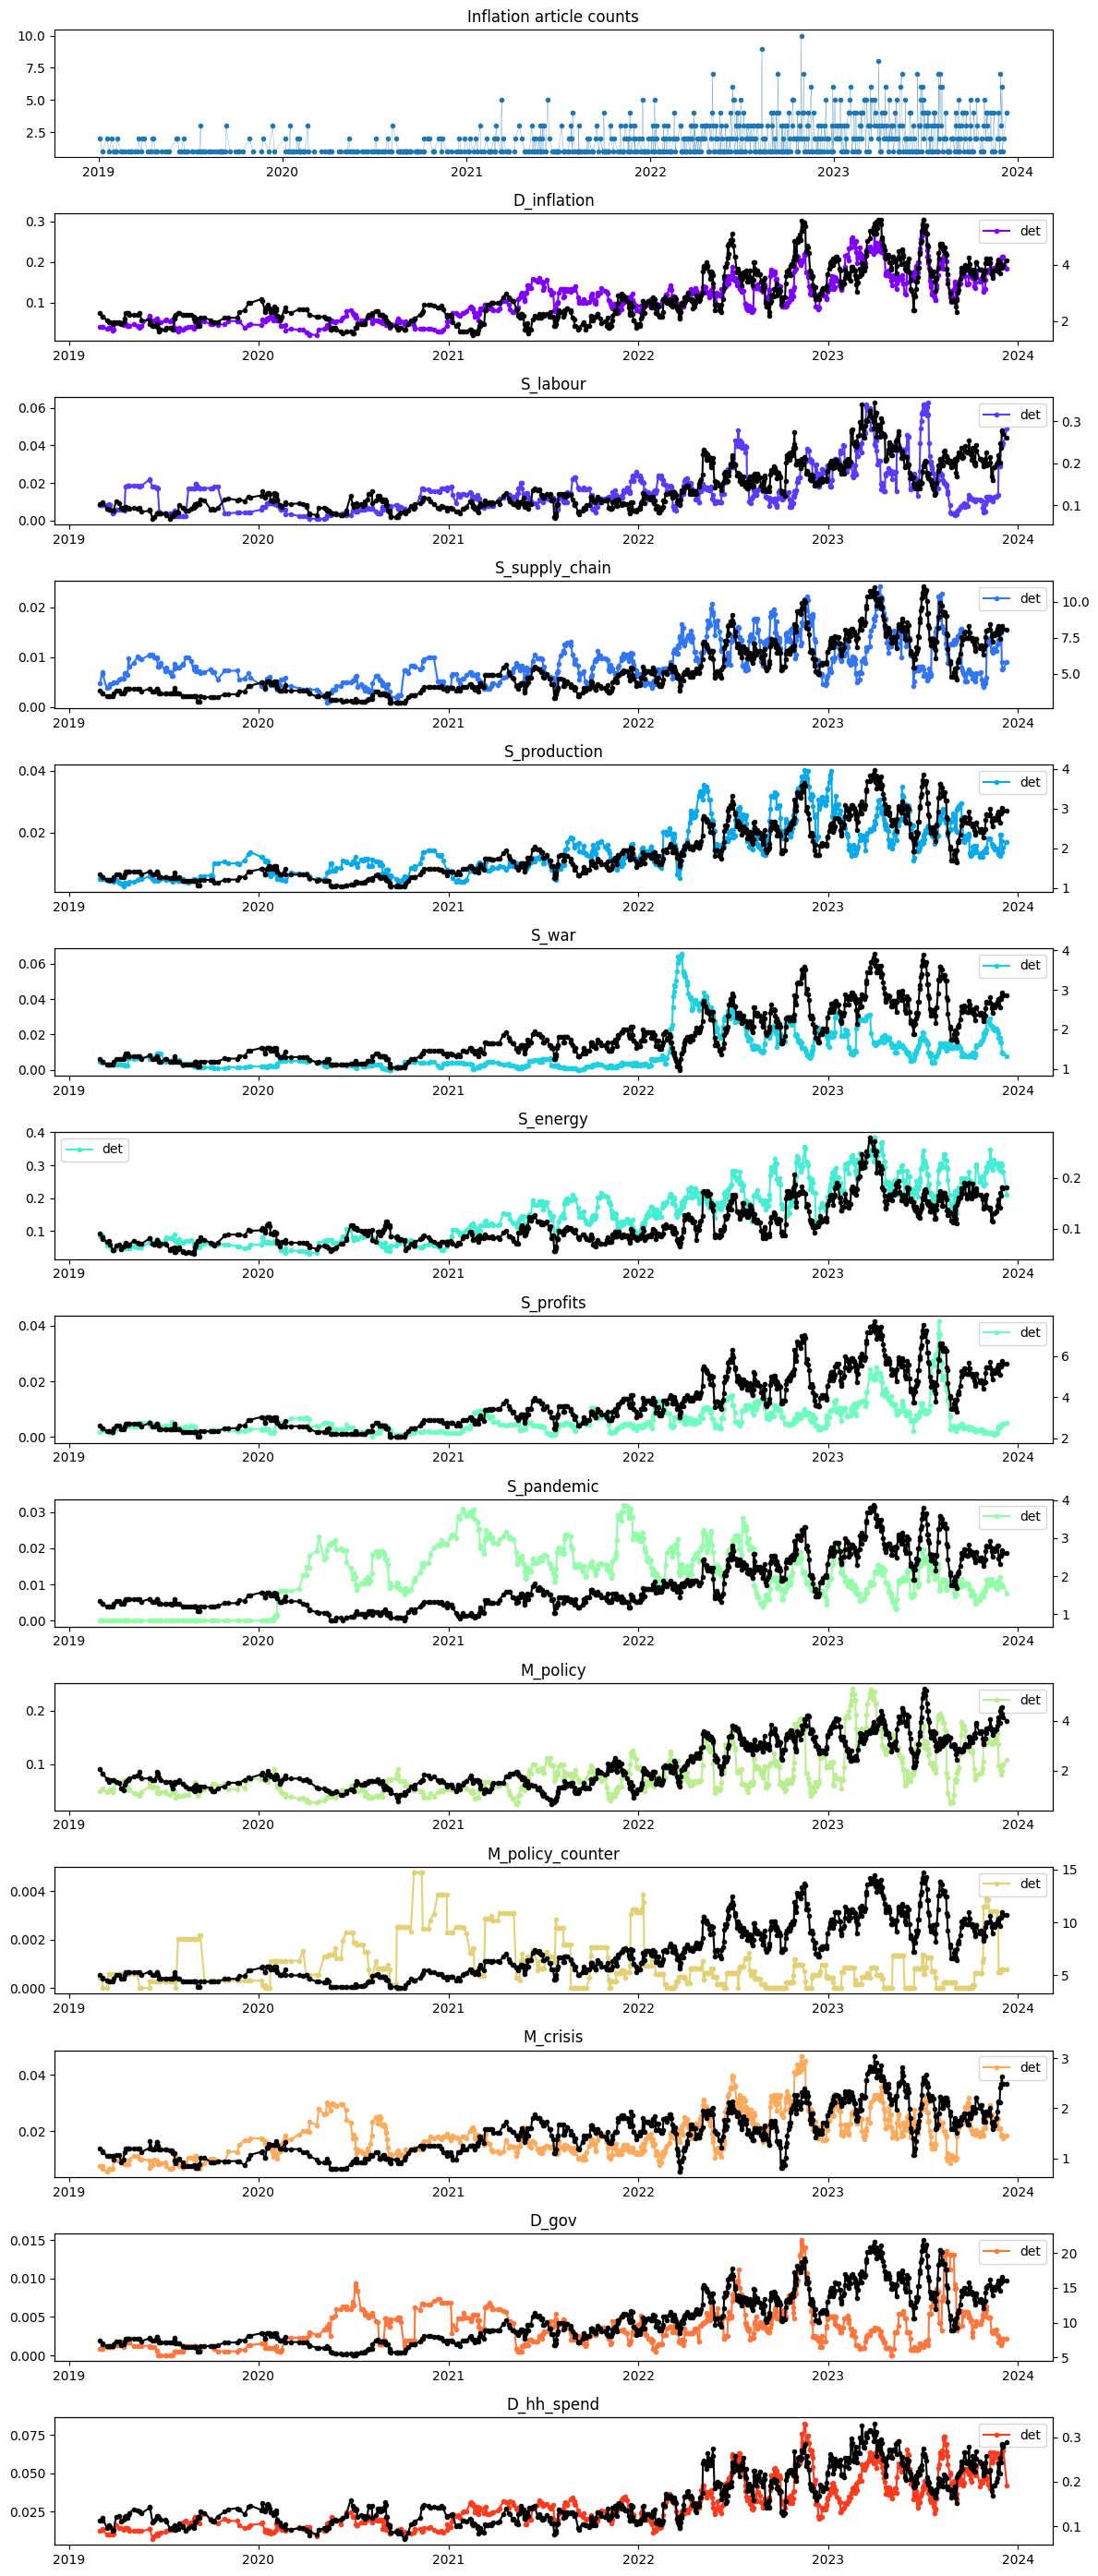

In [22]:
nrows = df_g.shape[1] + 1
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

axes.ravel()[0].plot(df.groupby('date').id.count(), lw=0.2, marker='.')
axes.ravel()[0].set_title('Inflation article counts')
for i, ax in enumerate(axes.ravel()[1:]):
    ax.plot(df_g.iloc[:, i], c=color[i], marker='.', )
    ax.twinx().plot(df_g2.iloc[:, i], c='black', marker='.',)
    ax.set_title(label=df_g.columns[i])
    ax.legend(['det', 'sim'])
            
    
plt.tight_layout()

In [23]:
save_pd_df(df, "det_topics.feather")